# GTSRB - German Traffic Sign Image Classification

In this project, we have a dataset containing images of 43 German traffic signs. We will create a model that recognizes traffic signs using deep learning. Then, we will measure the success rate by testing the model on test data. Additionally, we will convert our model into a web application using Streamlit

<img src='https://d1gymyavdvyjgt.cloudfront.net/drive/images/uploads/headers/ws_cropper/1_0x0_790x520_0x520_german-road-signs-header.jpg'>

<a href='https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign'> Click here to reach dataset <a>

### Import Dataset

In [1]:
import numpy as np 
import pandas as pd 
import os
import numpy as np

import cv2
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = '/kaggle/input/gtsrb-german-traffic-sign'
train_path = '/kaggle/input/gtsrb-german-traffic-sign/Train/'
test_csv_path = '/kaggle/input/gtsrb-german-traffic-sign/Test.csv'

In [3]:
category_quantity=len(os.listdir(train_path))
category_quantity

43

In [4]:
img_list=[]
encode_label_list=[]
for folder in os.listdir(train_path):
    folder_path=os.path.join(train_path,folder)
    for filename in os.listdir(folder_path):
        img_path=os.path.join(folder_path,filename)
        img_list.append(img_path)
        encode_label_list.append(folder)

In [5]:
df=pd.DataFrame({'img':img_list,'encode_label':encode_label_list})

In [6]:
df.head()

,img,encode_label
0,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
1,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
2,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
3,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
4,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7


In [7]:
df.sample(5)

,img,encode_label
37643,/kaggle/input/gtsrb-german-traffic-sign/Train/...,11
13872,/kaggle/input/gtsrb-german-traffic-sign/Train/...,25
35719,/kaggle/input/gtsrb-german-traffic-sign/Train/...,40
13186,/kaggle/input/gtsrb-german-traffic-sign/Train/...,25
36658,/kaggle/input/gtsrb-german-traffic-sign/Train/...,11


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   img           39209 non-null  object
 1   encode_label  39209 non-null  object
dtypes: object(2)
memory usage: 612.8+ KB


In [9]:
df['encode_label']=df['encode_label'].astype('int64')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   img           39209 non-null  object
 1   encode_label  39209 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 612.8+ KB


In [11]:
labels = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' 
            }

In [12]:
df['label']=df['encode_label'].map(labels)

In [13]:
df.sample(5)

,img,encode_label,label
2761,/kaggle/input/gtsrb-german-traffic-sign/Train/...,22,Bumpy road
32736,/kaggle/input/gtsrb-german-traffic-sign/Train/...,4,Speed limit (70km/h)
13335,/kaggle/input/gtsrb-german-traffic-sign/Train/...,25,Road work
13256,/kaggle/input/gtsrb-german-traffic-sign/Train/...,25,Road work
2057,/kaggle/input/gtsrb-german-traffic-sign/Train/...,17,No entry


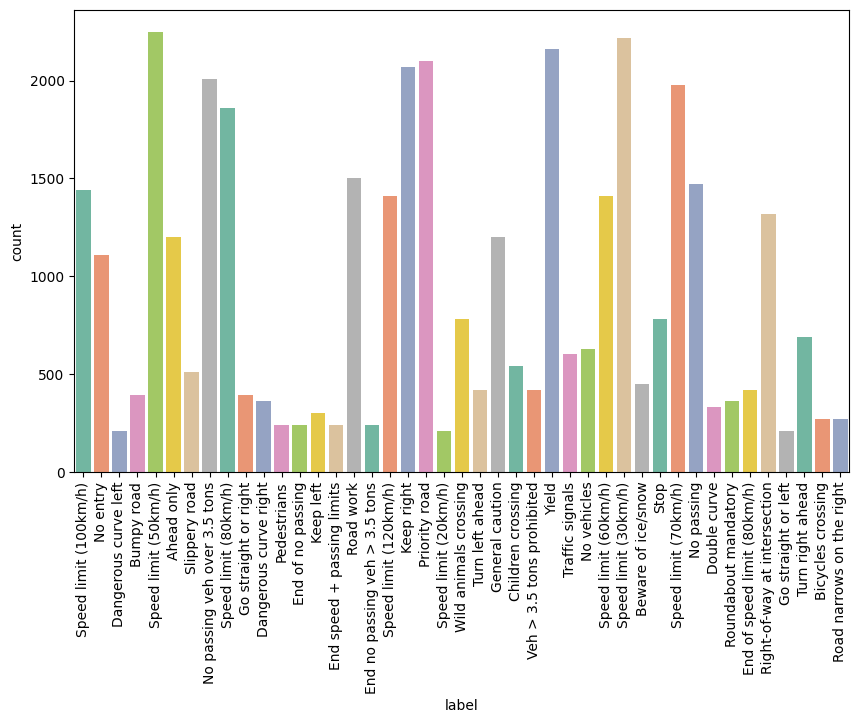

In [14]:
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=df,palette='Set2')
plt.xticks(rotation=90);

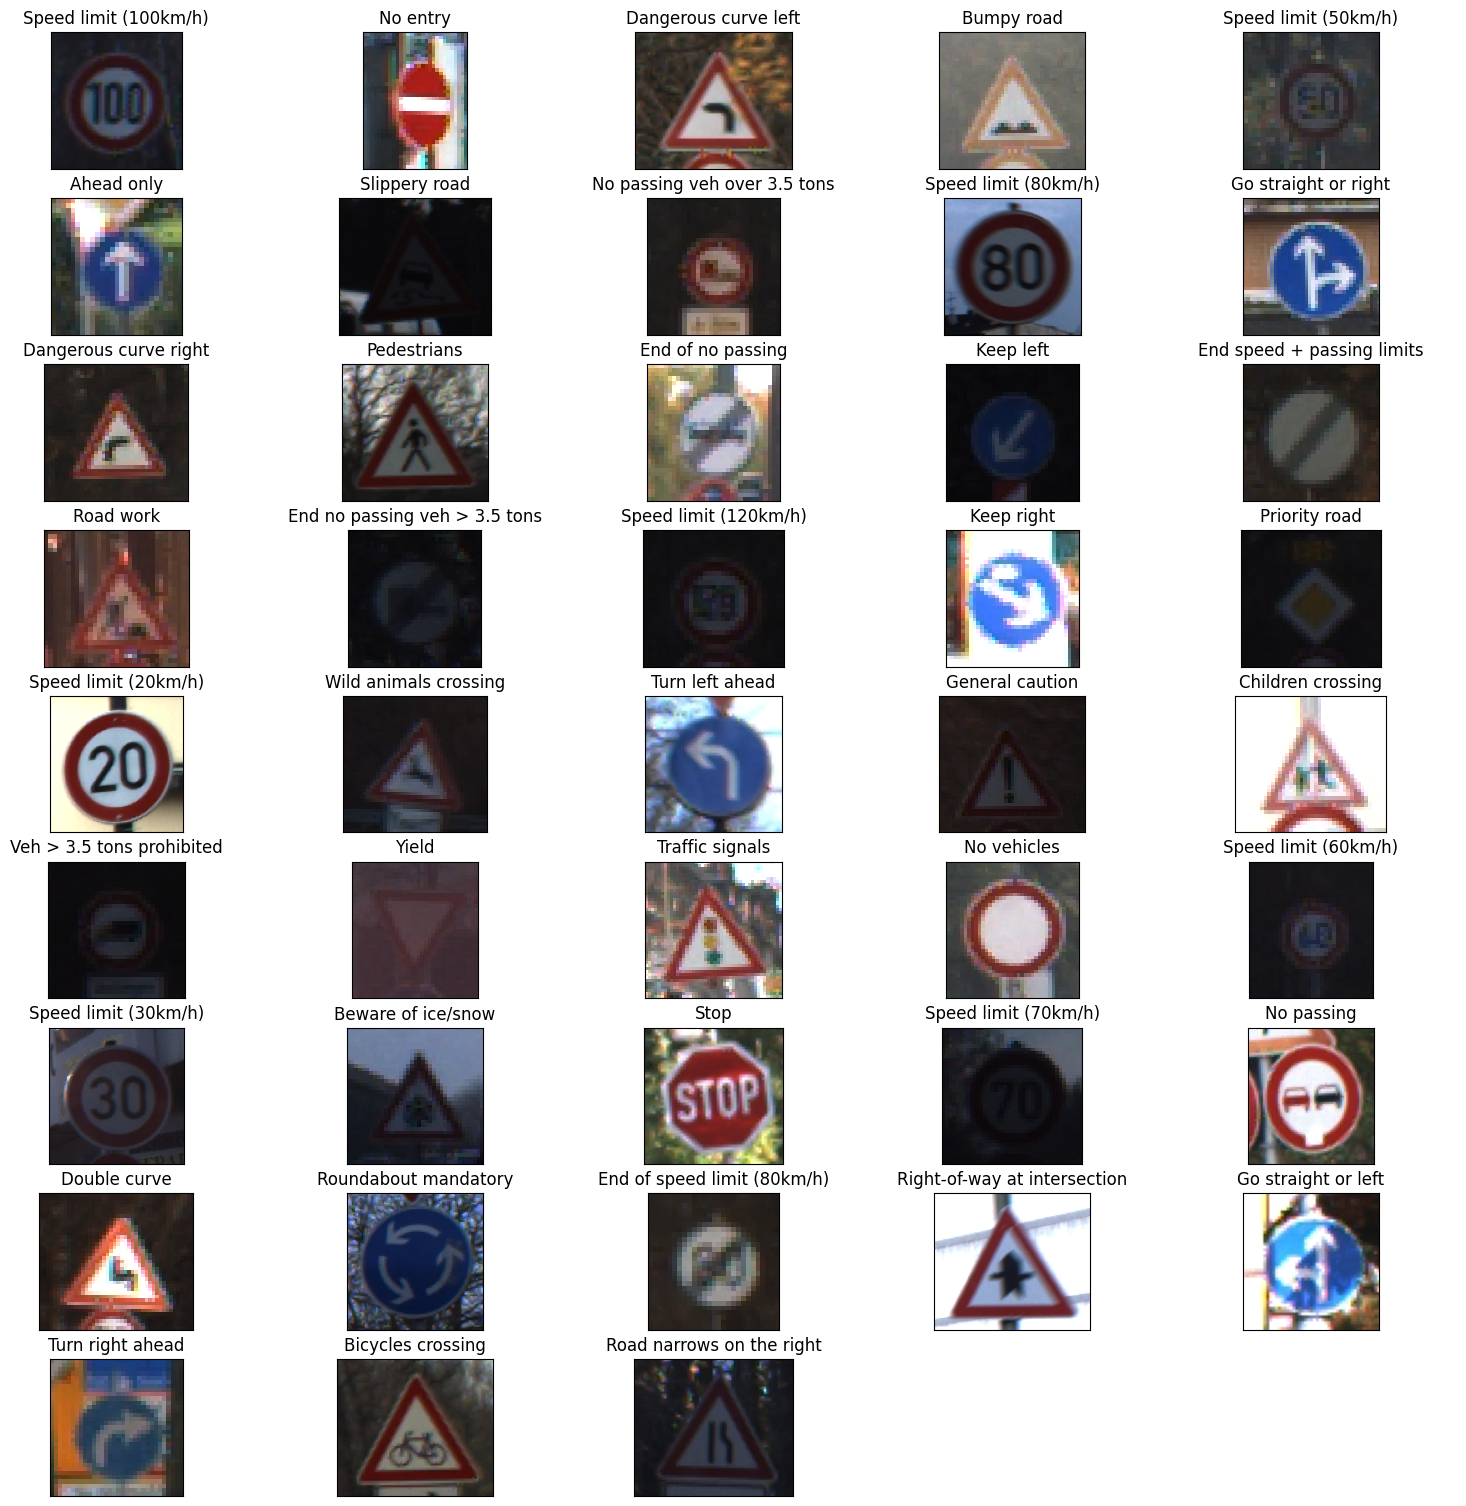

In [15]:
df_unique = df.copy().drop_duplicates(subset=["label"]).reset_index()

num_images = len(df_unique)

fig, axes = plt.subplots(nrows=9, ncols=5, figsize=(15, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(plt.imread(df_unique['img'][i]))
        ax.set_title(df_unique['label'][i], fontsize=12)
    else:
        ax.axis('off')

plt.tight_layout(pad=0.5)
plt.show()

### Deep Learning

We will identify x and y datas.

In [16]:
x=[]
for img in df['img']:
    img=cv2.imread(img)
    img=cv2.resize(img,(32,32)) #We resized the image to 32x32 pixels.
    img=img/255.0 #normalize the data
    x.append(img)

In [17]:
x=np.array(x)

In [18]:
y=df['encode_label']

Let's import train test split and we will split%20 of our datas as test data.

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

CNN - Convolutional Neural Networks

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D,Dropout,BatchNormalization,Reshape
from sklearn.metrics import accuracy_score

In [22]:
model = Sequential()
model.add(Input(shape=(32,32,3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [23]:
history = model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test),verbose=1)

Epoch 1/10


I0000 00:00:1729316605.171409      74 service.cc:145] XLA service 0x7c6774004d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729316605.171460      74 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729316605.171467      74 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 73/981 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0678 - loss: 3.5798

I0000 00:00:1729316608.168855      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4856 - loss: 1.9465 - val_accuracy: 0.9211 - val_loss: 0.2990
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9490 - loss: 0.2012 - val_accuracy: 0.9566 - val_loss: 0.1602
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9756 - loss: 0.0930 - val_accuracy: 0.9725 - val_loss: 0.1097
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9836 - loss: 0.0632 - val_accuracy: 0.9792 - val_loss: 0.0820
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9878 - loss: 0.0461 - val_accuracy: 0.9751 - val_loss: 0.0997
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9922 - loss: 0.0306 - val_accuracy: 0.9852 - val_loss: 0.0659
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9934 - loss: 0.0259 - val_accuracy: 0.9847 - val_loss: 0.0725
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9949 - loss: 0.0192 - val_accuracy: 0.9850 - val_

In [24]:
model.save('GTSRB_model.h5')

### Testing Model

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
df_test = pd.read_csv(test_csv_path)

In [27]:
df_test.sample(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
10153,125,113,11,10,114,104,13,Test/10153.png
5275,99,100,8,9,91,92,12,Test/05275.png
3099,37,41,5,5,32,36,5,Test/03099.png
6027,50,47,6,5,45,42,34,Test/06027.png
4293,35,34,6,5,30,29,35,Test/04293.png


In [28]:
y_true = df_test['ClassId'].values

In [29]:
y_pred = []

for img_name in df_test['Path'].values:
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (32, 32))
    img = img / 255.0 
    img = np.expand_dims(img, axis=0)
    
    prediction = model.predict(img,verbose=0)
    predicted_class = np.argmax(prediction)
    
    y_pred.append(predicted_class)

In [30]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.9234362628661916

### Conclusion

We turned the file paths of the traffic sign images obtained from Kaggle.com into a DataFrame with the help of the Pandas and OS libraries. Then, we sequentially read all the images using the OpenCV library and normalized them for easier processing. Afterward, we trained our model using Keras deep learning. We save our model and we can predict traffic sign now.